## Analysis of Experiments

An experiment was performed with 329 randomly generated problem instances.

For each problem instance 15 optimisations were performed arising from the product of each of the 5 available models:

- L1 norm models : "MR_milp_l1", "MR_cons_relax_l1", "MR_milp_l1_sos"

- L2 norm models : "MR_quad", "MR_cons_relax_l2"

and each of the three heuristics: "rounding", "iterative rounding" and "skip" (i.e. no heuristic).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from matrix_revisited import root_dir

In [2]:
# cleaned data
data = (
    pd.read_pickle(str(root_dir / "pickles" / "data.pkl"))
    .eval("root_solution_ratio = root_solution/objective_value")
)
data.head()

,model,heuristic,runtime,root_solution,objective_value,instance,root_solution_ratio
0,MR_quad,skip,0.825229,179380.0,18230.0,1,9.839824
1,MR_quad,rounding,0.853928,18260.0,18230.0,1,1.001646
2,MR_quad,iterative_rounding,0.687930,18230.0,18230.0,1,1.000000
3,MR_cons_relax_l1,skip,0.559011,5858.0,1482.0,1,3.952767
4,MR_cons_relax_l1,rounding,0.457798,1560.0,1482.0,1,1.052632


In [3]:
l1_models = ["MR_milp_l1", "MR_cons_relax_l1", "MR_milp_l1_sos"]
l2_models = ["MR_quad", "MR_cons_relax_l2"]

sns.set_palette(sns.color_palette("Set2"))

### Heuristic performance

A comparison is made with the objective value for the first solution found and the known optimal objective value.
When a heuristic is used (i.e. not "skip") then this solution is the one provided by the heuristic.

In [4]:
def boxplot_root_obj_ratio(obj_metric):
    models = l1_models if obj_metric == "l1" else l2_models
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    sns.boxplot(
        data=data.query("model in @models"),
        x="root_solution_ratio", y="heuristic", orient="h", notch=True, ax=ax1,
    )
    sns.ecdfplot(
        data=data.query("model in @models and heuristic != 'skip'").reset_index(),
        x="root_solution_ratio", hue="heuristic", ax=ax2
    )
    fig.suptitle(f"Ratio of first solution objective value to optimal objective value: {obj_metric}")
    fig.tight_layout()

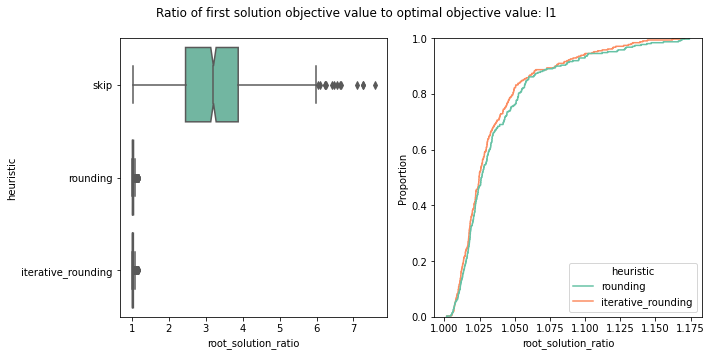

In [5]:
boxplot_root_obj_ratio(obj_metric="l1")

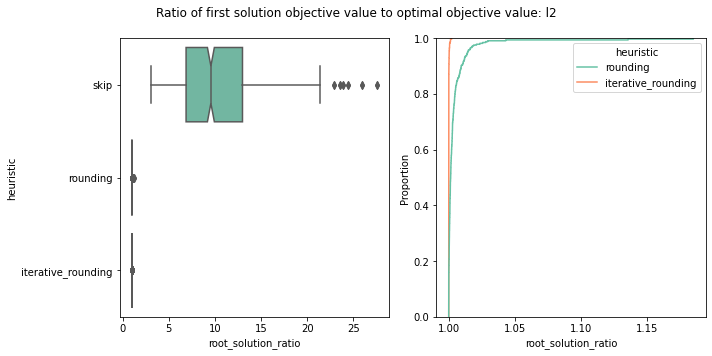

In [6]:
boxplot_root_obj_ratio(obj_metric="l2")

In [7]:
# average 'root solution ratio' for iterative rounding with L2 norm
(
    data
    .query("model in @l2_models and heuristic == 'iterative_rounding'")
    .loc[:,"root_solution_ratio"]
    .mean()
)

1.0000634076190011

### Comparison of runtimes across models and heuristics

In [8]:
def series_ratio(df, series_name):
    df[series_name + "_ratio"] = df[series_name]/df[series_name].min()
    return df


def boxplot(df, compare, ax=None):
    """ compare : {"model", "heuristic"} """
    
    y = "model" if compare == "heuristic" else "heuristic"
    groupbys = ["instance", y]

    ax=sns.boxplot(
        data=df.groupby(groupbys).apply(series_ratio, "runtime"),
        x="runtime_ratio", y=y, hue=compare, orient="h", ax=ax, notch=True,
    )
    sns.despine(top=True, right=True, ax=ax)
    ax.legend(
        bbox_to_anchor=(0.5, 1.12),
        ncol=df[compare].nunique(),
        loc="upper center",
    )


def ecdf(df, which, compare, ax=None):
    """ compare : {"model", "heuristic"} """
    query_col = "model" if compare == "heuristic" else "heuristic"
    ax = sns.ecdfplot(
        data=(
            df.query(f"{query_col} == @which")
            .groupby("instance")
            .apply(series_ratio, "runtime")
            .reset_index()
        ),
        x="runtime_ratio", hue=compare, ax=ax,
    )
    sns.despine(top=True, right=True, ax=ax)
    ax.set_title(which)
    return ax


def dash(df, compare):
    cat_col = "model" if compare == "heuristic" else "heuristic"

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(2,1,1)
    boxplot(df, compare, ax)
    for i, cat in enumerate(df[cat_col].unique()):
        ax = fig.add_subplot(2,df[cat_col].nunique(),df[cat_col].nunique()+i+1)
        ecdf(df, cat, compare, ax)
    fig.tight_layout()
    plt.show()

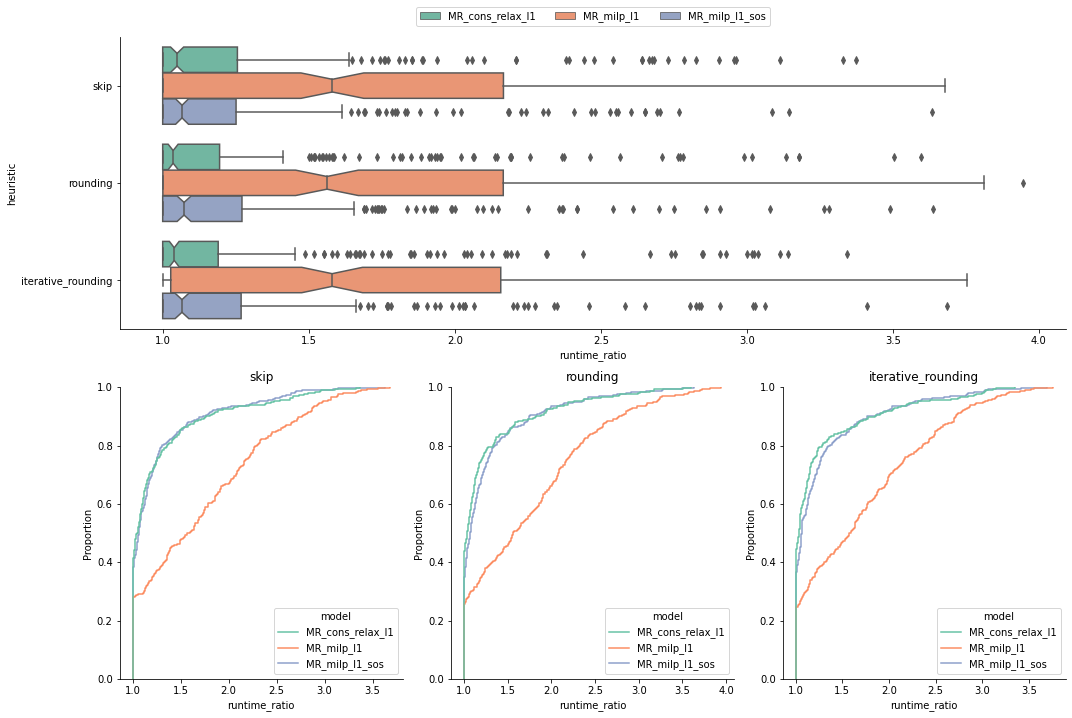

In [9]:
dash(data.query("model in @l1_models"), compare="model")

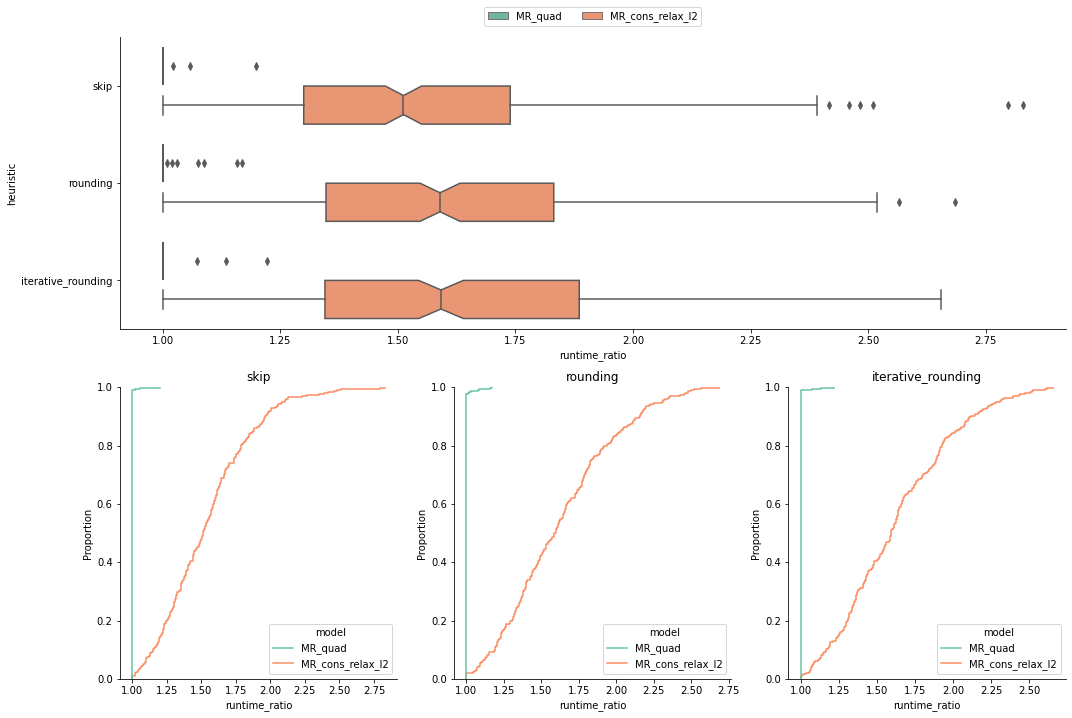

In [10]:
dash(data.query("model in @l2_models"), compare="model")

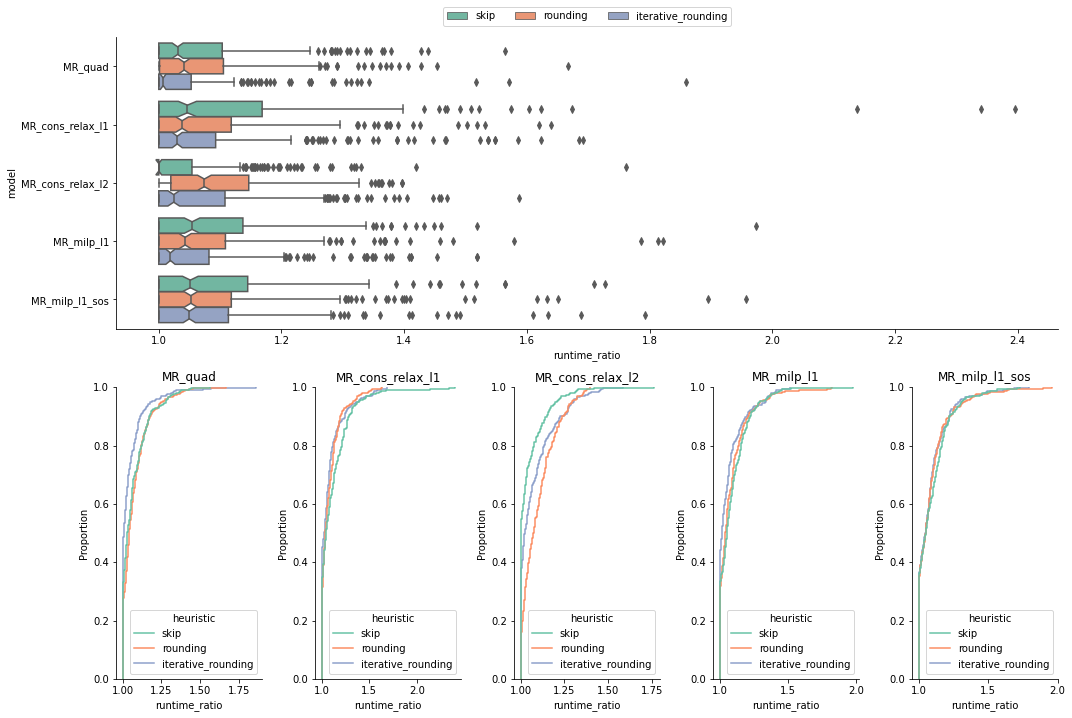

In [11]:
dash(data, compare="heuristic")

### Conclusions

- The rounding and iterative rounding heuristics provide a strong upper bound.

- For the L1 norm the iterative rounding heuristic is only slightly better than the rounding heuristic.

- For the L2 norm the iterative rounding heuristic definitively outperforms the rounding heuristic, providing an average gap of 0.006% to the optimal solution.

- For the models using a L1 norm the MR_cons_relax_l1 model is the generally the fastest, followed closely by MR_milp_l1_sos, and then MR_milp_l1 (which is considerably worse).

- For the models using a L2 norm the MR_quad model, without question, outperforms the MR_cons_relax_l2 model.

- In general using one of the two heuristics leads to a better runtime than not, with MR_cons_relax_l2 being an exception.  

- Amongst all models, the iterative rounding heuristic leads to a better average runtime than the rounding heuristic.
